# Azure AI Human Detection Pipeline

Amanda Sumner  
September 2025

This Jupyter Notebook serves as a detailed analysis of the results from the **Azure AI human detection pipeline**. Its primary purpose is to load and process the JSON reports generated by the Azure Function. The analysis aims to demonstrate the pipeline's functionality and provide insights into the behaviour of the **Azure AI Vision** service on a sample dataset.

## Setup and data loading

In [3]:
from azure.storage.blob import BlobServiceClient
import os
import json
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns

In [8]:
load_dotenv(dotenv_path=".env")

connect_str = os.getenv("AzureWebJobsStorage")
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client("analysis-results")

reports = []
blob_list = container_client.list_blobs()
for blob in blob_list:
    download_stream = container_client.get_blob_client(blob).download_blob()
    json_data = json.loads(download_stream.readall())
    reports.append(json_data)

df = pd.DataFrame(reports)
print(f"Loaded {len(df)} reports.")

Loaded 30 reports.


In [9]:
df.head(10)


,image_name,human_detected,detection_details
0,1.png,True,"[{'confidence': 0.8913525342941284, 'bounding_..."
1,101.png,True,"[{'confidence': 0.9336774945259094, 'bounding_..."
2,102.png,True,"[{'confidence': 0.040830761194229126, 'boundin..."
3,11.png,True,"[{'confidence': 0.93868088722229, 'bounding_bo..."
4,111.png,True,"[{'confidence': 0.9183581471443176, 'bounding_..."
5,112.png,True,"[{'confidence': 0.006021004170179367, 'boundin..."
6,121.png,True,"[{'confidence': 0.9294695258140564, 'bounding_..."
7,126.png,True,"[{'confidence': 0.002122970763593912, 'boundin..."
8,131.png,True,"[{'confidence': 0.940255880355835, 'bounding_b..."
9,132.png,True,"[{'confidence': 0.7138572931289673, 'bounding_..."


In [7]:
# Define the local file path to save the DataFrame
local_file_path = 'reports_dataframe.pkl'

# Save the DataFrame to a pickle file
df.to_pickle(local_file_path)

print(f"DataFrame saved to {local_file_path}")

DataFrame saved to reports_dataframe.pkl


In [4]:
# Load the DataFrame from the pickle file
local_file_path = 'reports_dataframe.pkl'
df = pd.read_pickle(local_file_path)    

In [26]:
total_images = len(df)
images_with_detections = df['human_detected'].sum()
total_detections = df['detection_details'].apply(len).sum()

print(f"Total images processed: {total_images}")
print(f"Images with at least one human detected: {images_with_detections}")
print(f"Total number of humans detected: {total_detections}")
print(f"Detection rate: {images_with_detections / total_images * 100:.2f}%")

Total images processed: 30
Images with at least one human detected: 18
Total number of humans detected: 39
Detection rate: 60.00%


### Distribution of Detection Confidence Scores  

The following histogram shows the spread of confidence scores from all the human detections. A high-performing model will have a distribution that is skewed towards the right, meaning it is often highly confident (scores closer to 1.0) when it detects a human. 

The chart shows detections with the 0.1 threshold applied, to filter out false positives with the lowest confidence levels.

In [5]:
# Setting a confidence threshold
threshold = 0.1

# Filtering the detection_details to only keep those above the threshold
df['detection_details'] = df['detection_details'].apply(
    lambda details: [d for d in details if d['confidence'] >= threshold]
)

df['human_detected'] = df['detection_details'].apply(lambda x: len(x) > 0)

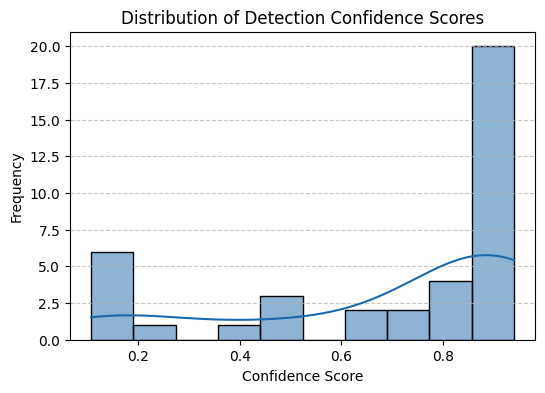

In [6]:
df_detections = df.explode('detection_details').dropna(subset=['detection_details'])
df_detections['confidence'] = df_detections['detection_details'].apply(lambda x: x['confidence'])

plt.figure(figsize=(6, 4))
sns.histplot(df_detections['confidence'], bins=10, kde=True, color="#1c6aad")
plt.title('Distribution of Detection Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### An example image with bounding boxes and confidence levels drawn on it from the analysis report.

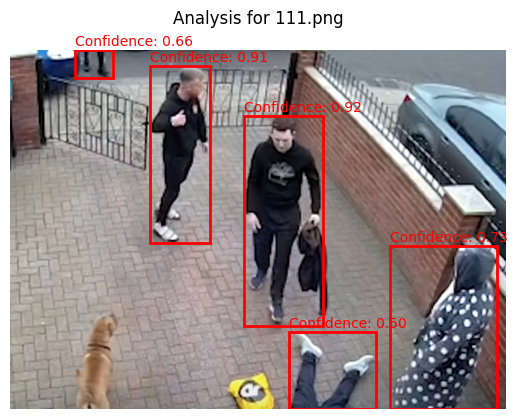

In [7]:
# The path to the local image file
image_path = '../samples/images/111.png'
image_filename = os.path.basename(image_path)

# Find the corresponding analysis report in DataFrame
try:
    analysis_report = df[df['image_name'] == image_filename].iloc[0]
except IndexError:
    print(f"Error: No analysis report found for {image_filename} in the DataFrame.")
    analysis_report = None

if analysis_report is not None:
   
    img = Image.open(image_path)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Iterate through the detection details and draw bounding boxes
    for detail in analysis_report['detection_details']:
        
        bbox = detail['bounding_box']
        x, y, width, height = bbox['x'], bbox['y'], bbox['width'], bbox['height']
        
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor='r', facecolor='none'
        )
        
        ax.add_patch(rect)
        
        confidence = detail['confidence']
        plt.text(
            x, y - 5, f'Confidence: {confidence:.2f}', color='red', fontsize=10)
    plt.axis('off')  
    plt.title(f'Analysis for {image_filename}', y=1.05)
    plt.show()

### Number of Human Detections Per Image  

This bar chart gives a clear visual count of how many people were detected in each image. It is useful for quickly identifying which images had the most detections. It can be used to spot any potential anomalies in the dataset or to see if the model detected multiple individuals correctly in a single photo.

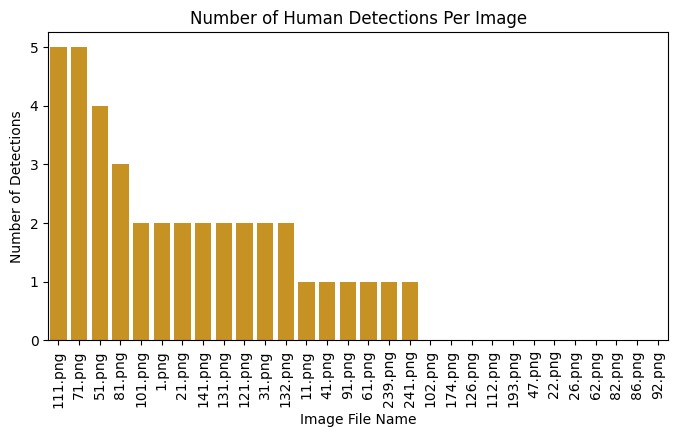

In [30]:
df['detections_count'] = df['detection_details'].apply(len)
df_detections_by_image = df.sort_values('detections_count', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=df_detections_by_image['image_name'], y=df_detections_by_image['detections_count'], color="#e09c08")
plt.title('Number of Human Detections Per Image')
plt.xlabel('Image File Name')
plt.ylabel('Number of Detections')
plt.xticks(rotation=90)
plt.show()

### Confidence Score vs. Bounding Box Area  

This scatter plot helps us explore the relationship between the size of the detected person in the image and the model's confidence in its prediction. By plotting confidence against the area of the bounding box, we can see if the model performs better on larger, more prominent objects or if it is equally confident with smaller detections. This type of analysis can reveal potential biases or strengths in the AI model's performance.  

The plot reveals a clear trend: the model's confidence is strongly influenced by the size of the bounding box. For smaller bounding box areas (indicating smaller objects), the confidence scores are more varied, ranging from very low to high. However, as the bounding box area increases, the confidence scores generally rise and become more consistently high.

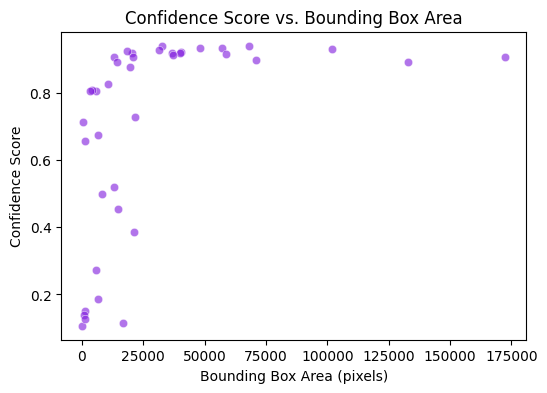

In [33]:
# Extract bounding box size
df_detections['bbox_area'] = df_detections['detection_details'].apply(
    lambda x: x['bounding_box']['width'] * x['bounding_box']['height']
)

plt.figure(figsize=(6, 4))
sns.scatterplot(x='bbox_area', y='confidence', data=df_detections, color="#7e18dd", alpha=0.6)
plt.title('Confidence Score vs. Bounding Box Area')
plt.xlabel('Bounding Box Area (pixels)')
plt.ylabel('Confidence Score')
plt.show()